In [1]:
import torch

In [2]:
!pip3 freeze | grep torch

torch==1.6.0
torchsummary==1.5.1
torchvision==0.7.0


In [3]:
import torch.utils.data as data
from torchvision import transforms, datasets

In [4]:
def get_celeba(root, split, download=True):
    transform = transforms.Compose([
        transforms.Resize(64),
        transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ])
    return datasets.CelebA(root, split=split, transform=transform,
        download=download)

def get_data():
    dataset_train = get_celeba('~/data', 'train',)
    dataset_test = get_celeba('~/data', 'test')
    print('train', len(dataset_train))
    print('test', len(dataset_test))
    return dataset_train, dataset_test

dataset_train, dataset_test = get_data()

Files already downloaded and verified
Files already downloaded and verified
train 162770
test 19962


In [5]:
batch_size = 128
workers = 4
train_data = data.DataLoader(dataset_train, batch_size=batch_size,
                             num_workers=workers, drop_last=True, shuffle=True)
test_data = data.DataLoader(dataset_test, batch_size=batch_size,
                             num_workers=workers, drop_last=True)

In [6]:
import matplotlib.pyplot as plt

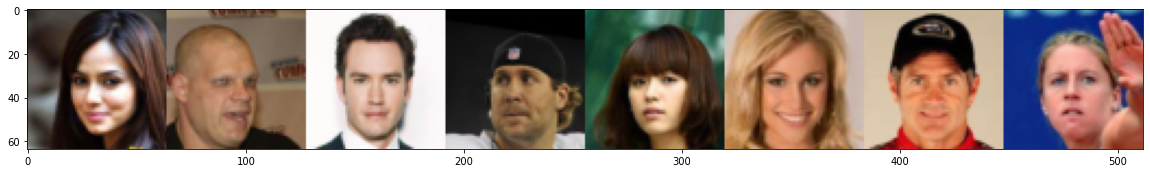

<Figure size 432x288 with 0 Axes>

In [7]:
def plot_imgs(img, save_file=False, file_name='out'):
    img = img.permute(1, 2, 0, 3).reshape(3, 64, -1)
    img = (img + 1) / 2
    plt.figure(figsize=(20,10))
    plt.imshow(img.permute(1, 2, 0))
    plt.show()
    plt.savefig(file_name)

plot_imgs(next(iter(train_data))[0][:8])

In [8]:
import torch
from torch import nn
import torch.nn.functional as F

latent_dim = 128
g_hidden = 64 # hidden dim of generator
d_hidden = 64 # hidden dim of discriminator

class Generator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, g_hidden * 8,
                kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(g_hidden * 8),
            nn.ReLU(inplace=True),
            # shape is (g_hidden*8, 4, 4),

            nn.ConvTranspose2d(g_hidden * 8, g_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_hidden * 4),
            nn.ReLU(inplace=True),
            # shape is (g_hidden*4, 8, 8),

            nn.ConvTranspose2d(g_hidden * 4, g_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_hidden * 2),
            nn.ReLU(inplace=True),
            # shape is (g_hidden*2, 16, 16),

            nn.ConvTranspose2d(g_hidden * 2, g_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(g_hidden),
            nn.ReLU(inplace=True),
            # shape is (g_hidden, 32, 32),

            nn.ConvTranspose2d(g_hidden, 3,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.Tanh(),
            # shape is (3, 64, 64),
        )

    def forward(self, x):
        output = self.main(x)
        return output

class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.main = nn.Sequential(
            nn.Conv2d(3, d_hidden,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # shape is (d_hidden, 32, 32),

            nn.Conv2d(d_hidden, d_hidden * 2,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_hidden * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # shape is (d_hidden * 2, 16, 16),

            nn.Conv2d(d_hidden * 2, d_hidden * 4,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_hidden * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # shape is (d_hidden * 4, 8, 8),

            nn.Conv2d(d_hidden * 4, d_hidden * 8,
                kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(d_hidden * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # shape is (d_hidden * 8, 4, 4),

            nn.Conv2d(d_hidden * 8, 1,
                kernel_size=4, stride=1, padding=0, bias=False),
            nn.Sigmoid()
            # shape is (1, 1, 1)
        )

    def forward(self, x):
        output = self.main(x)
        return output.view(-1, 1).squeeze(1)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)

In [9]:
def test_model():
    # test whether our model works fine
    net_d = Discriminator()
    net_g = Generator()

    x = torch.rand(16, latent_dim, 1, 1)

    out = net_g(x)
    print(out.shape)
    out2 = net_d(out)
    print(out2.shape)
test_model()

torch.Size([16, 3, 64, 64])
torch.Size([16])


In [10]:
# setting
lr = 2e-4
beta1 = 0.5
start_epoch = 1
max_epoch = 10

import os
os.makedirs('ckpts', exist_ok=True)
os.makedirs('out_imgs', exist_ok=True)

In [11]:
device = torch.device('cuda:1')

net_g = Generator().to(device)
net_g.apply(weights_init)
# print(net_g)

net_d = Discriminator().to(device)
net_d.apply(weights_init)
# print(net_g)

criterion = nn.BCELoss()

optim_d = torch.optim.AdamW(net_d.parameters(), lr=lr, betas=(beta1, 0.99))
optim_g = torch.optim.AdamW(net_g.parameters(), lr=lr, betas=(beta1, 0.99))

In [12]:
# label setting
fixed_noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
real_label = torch.ones(batch_size, device=device).float()
fake_label = torch.zeros(batch_size, device=device).float()

[1/10 - 0/1271] Loss_D: 1.4985 Loss_G: 5.9679   D(G(z)): 0.6754 / 0.5792 / 0.0039
[1/10 - 127/1271] Loss_D: 1.2494 Loss_G: 3.0616   D(G(z)): 0.5056 / 0.0219 / 0.0819
[1/10 - 254/1271] Loss_D: 1.3242 Loss_G: 4.1673   D(G(z)): 0.3995 / 0.0135 / 0.0453
[1/10 - 381/1271] Loss_D: 0.7182 Loss_G: 2.2279   D(G(z)): 0.6204 / 0.0511 / 0.1510
[1/10 - 508/1271] Loss_D: 0.4879 Loss_G: 5.0362   D(G(z)): 0.9322 / 0.2833 / 0.0200
[1/10 - 635/1271] Loss_D: 0.6996 Loss_G: 3.2580   D(G(z)): 0.7022 / 0.1542 / 0.0630
[1/10 - 762/1271] Loss_D: 0.3710 Loss_G: 4.4543   D(G(z)): 0.8384 / 0.1306 / 0.0201
[1/10 - 889/1271] Loss_D: 0.4070 Loss_G: 6.5623   D(G(z)): 0.9381 / 0.2366 / 0.0033
[1/10 - 1016/1271] Loss_D: 0.3016 Loss_G: 4.0531   D(G(z)): 0.8089 / 0.0535 / 0.0298
[1/10 - 1143/1271] Loss_D: 0.6433 Loss_G: 5.4077   D(G(z)): 0.8122 / 0.2639 / 0.0123
[1/10 - 1270/1271] Loss_D: 0.3348 Loss_G: 4.4719   D(G(z)): 0.7877 / 0.0299 / 0.0274


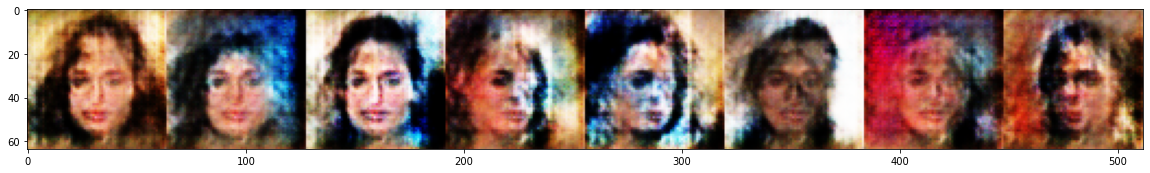

------------------------------
err_d 0.3348333537578583 4.471857070922852
[2/10 - 0/1271] Loss_D: 0.3726 Loss_G: 4.7320   D(G(z)): 0.9122 / 0.1996 / 0.0165
[2/10 - 127/1271] Loss_D: 1.1358 Loss_G: 7.0302   D(G(z)): 0.9511 / 0.5863 / 0.0017
[2/10 - 254/1271] Loss_D: 0.4047 Loss_G: 6.3502   D(G(z)): 0.9665 / 0.2728 / 0.0032
[2/10 - 381/1271] Loss_D: 0.5743 Loss_G: 4.1186   D(G(z)): 0.7951 / 0.2450 / 0.0248
[2/10 - 508/1271] Loss_D: 0.4403 Loss_G: 3.4529   D(G(z)): 0.7866 / 0.1225 / 0.0624
[2/10 - 635/1271] Loss_D: 0.4900 Loss_G: 3.5066   D(G(z)): 0.8038 / 0.1780 / 0.0483
[2/10 - 762/1271] Loss_D: 0.3336 Loss_G: 4.3648   D(G(z)): 0.8675 / 0.1438 / 0.0266
[2/10 - 889/1271] Loss_D: 0.4482 Loss_G: 4.1540   D(G(z)): 0.8398 / 0.1841 / 0.0283
[2/10 - 1016/1271] Loss_D: 0.6839 Loss_G: 2.4818   D(G(z)): 0.6318 / 0.0827 / 0.1194
[2/10 - 1143/1271] Loss_D: 0.4984 Loss_G: 2.6898   D(G(z)): 0.7670 / 0.1709 / 0.0907
[2/10 - 1270/1271] Loss_D: 0.4130 Loss_G: 3.6213   D(G(z)): 0.8845 / 0.2110 / 0.0439


<Figure size 432x288 with 0 Axes>

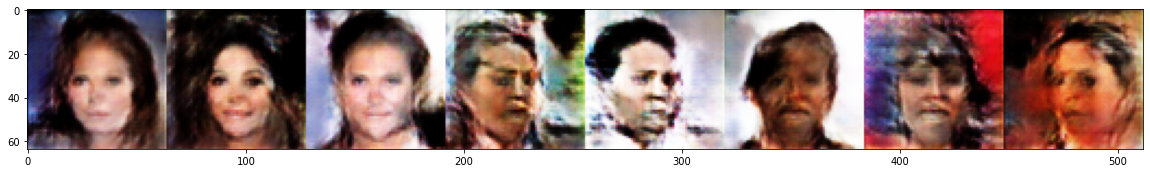

------------------------------
err_d 0.41300761699676514 3.6212644577026367
[3/10 - 0/1271] Loss_D: 0.7457 Loss_G: 2.3837   D(G(z)): 0.6773 / 0.2160 / 0.1252
[3/10 - 127/1271] Loss_D: 0.5680 Loss_G: 4.8377   D(G(z)): 0.8951 / 0.3052 / 0.0178
[3/10 - 254/1271] Loss_D: 0.7215 Loss_G: 2.6905   D(G(z)): 0.5747 / 0.0129 / 0.1112
[3/10 - 381/1271] Loss_D: 0.4327 Loss_G: 3.5327   D(G(z)): 0.9061 / 0.2481 / 0.0443
[3/10 - 508/1271] Loss_D: 0.5105 Loss_G: 1.7340   D(G(z)): 0.7496 / 0.1469 / 0.2279
[3/10 - 635/1271] Loss_D: 0.7449 Loss_G: 4.0760   D(G(z)): 0.8861 / 0.4141 / 0.0267
[3/10 - 762/1271] Loss_D: 1.0653 Loss_G: 1.8056   D(G(z)): 0.4847 / 0.1194 / 0.2299
[3/10 - 889/1271] Loss_D: 0.7170 Loss_G: 1.0039   D(G(z)): 0.7067 / 0.2574 / 0.4094
[3/10 - 1016/1271] Loss_D: 0.6033 Loss_G: 2.3305   D(G(z)): 0.7742 / 0.2528 / 0.1249
[3/10 - 1143/1271] Loss_D: 0.5075 Loss_G: 2.5010   D(G(z)): 0.8178 / 0.2218 / 0.1113
[3/10 - 1270/1271] Loss_D: 0.5725 Loss_G: 2.4460   D(G(z)): 0.8092 / 0.2599 / 0.1128

<Figure size 432x288 with 0 Axes>

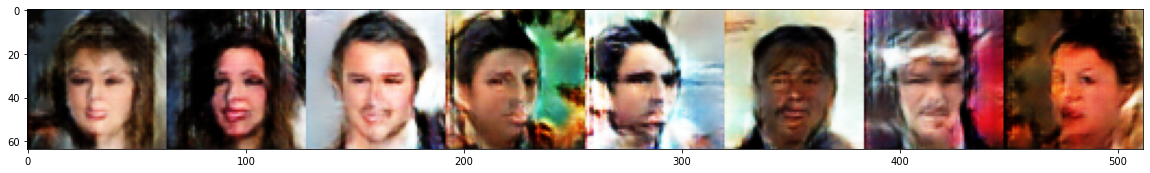

------------------------------
err_d 0.5724567770957947 2.44596266746521
[4/10 - 0/1271] Loss_D: 0.5664 Loss_G: 3.4988   D(G(z)): 0.8521 / 0.2953 / 0.0430
[4/10 - 127/1271] Loss_D: 0.4145 Loss_G: 2.6226   D(G(z)): 0.8419 / 0.1903 / 0.0929
[4/10 - 254/1271] Loss_D: 0.6046 Loss_G: 1.8283   D(G(z)): 0.7084 / 0.1862 / 0.2005
[4/10 - 381/1271] Loss_D: 0.9698 Loss_G: 3.6575   D(G(z)): 0.8988 / 0.5225 / 0.0368
[4/10 - 508/1271] Loss_D: 0.8514 Loss_G: 3.2020   D(G(z)): 0.8224 / 0.4353 / 0.0596
[4/10 - 635/1271] Loss_D: 0.8744 Loss_G: 2.6102   D(G(z)): 0.7071 / 0.3385 / 0.1039
[4/10 - 762/1271] Loss_D: 0.7483 Loss_G: 3.0811   D(G(z)): 0.7928 / 0.3522 / 0.0568
[4/10 - 889/1271] Loss_D: 0.8218 Loss_G: 1.7415   D(G(z)): 0.5354 / 0.0891 / 0.2270
[4/10 - 1016/1271] Loss_D: 0.6928 Loss_G: 1.7573   D(G(z)): 0.6210 / 0.1113 / 0.2187
[4/10 - 1143/1271] Loss_D: 0.5984 Loss_G: 1.5330   D(G(z)): 0.6478 / 0.1009 / 0.2672
[4/10 - 1270/1271] Loss_D: 0.3823 Loss_G: 2.6887   D(G(z)): 0.7733 / 0.0901 / 0.0880


<Figure size 432x288 with 0 Axes>

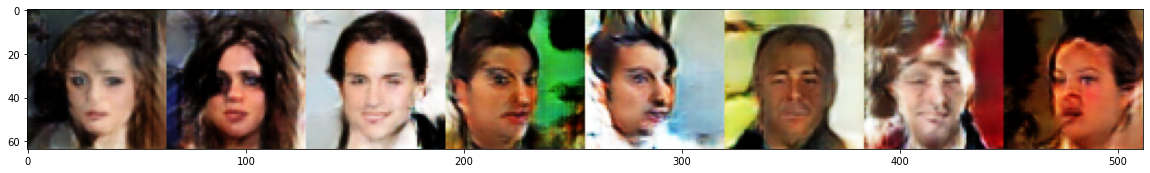

------------------------------
err_d 0.38229382038116455 2.688732862472534
[5/10 - 0/1271] Loss_D: 0.4670 Loss_G: 1.9226   D(G(z)): 0.7805 / 0.1692 / 0.1814
[5/10 - 127/1271] Loss_D: 0.6765 Loss_G: 2.3948   D(G(z)): 0.6450 / 0.1474 / 0.1317
[5/10 - 254/1271] Loss_D: 0.7135 Loss_G: 1.7949   D(G(z)): 0.5723 / 0.0731 / 0.2170
[5/10 - 381/1271] Loss_D: 0.4856 Loss_G: 2.4520   D(G(z)): 0.7762 / 0.1802 / 0.1124
[5/10 - 508/1271] Loss_D: 1.1528 Loss_G: 1.2467   D(G(z)): 0.3979 / 0.0460 / 0.3522
[5/10 - 635/1271] Loss_D: 0.7025 Loss_G: 3.7852   D(G(z)): 0.8745 / 0.3931 / 0.0343
[5/10 - 762/1271] Loss_D: 1.0808 Loss_G: 4.5682   D(G(z)): 0.9098 / 0.5769 / 0.0145
[5/10 - 889/1271] Loss_D: 0.6347 Loss_G: 2.6601   D(G(z)): 0.7698 / 0.2668 / 0.0942
[5/10 - 1016/1271] Loss_D: 0.9501 Loss_G: 3.9278   D(G(z)): 0.8843 / 0.5123 / 0.0289
[5/10 - 1143/1271] Loss_D: 0.5306 Loss_G: 2.1703   D(G(z)): 0.7508 / 0.1673 / 0.1460
[5/10 - 1270/1271] Loss_D: 0.5514 Loss_G: 2.1246   D(G(z)): 0.7007 / 0.1361 / 0.1496


<Figure size 432x288 with 0 Axes>

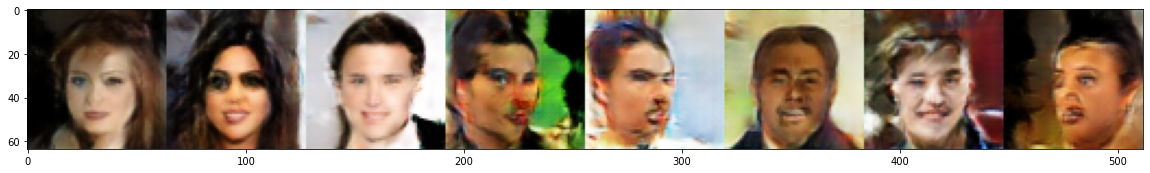

------------------------------
err_d 0.5513920187950134 2.124570846557617
[6/10 - 0/1271] Loss_D: 0.5476 Loss_G: 2.8908   D(G(z)): 0.8293 / 0.2695 / 0.0734
[6/10 - 127/1271] Loss_D: 0.8008 Loss_G: 4.0192   D(G(z)): 0.9457 / 0.4719 / 0.0239
[6/10 - 254/1271] Loss_D: 0.5244 Loss_G: 1.7966   D(G(z)): 0.6897 / 0.0978 / 0.2031
[6/10 - 381/1271] Loss_D: 0.5738 Loss_G: 2.0592   D(G(z)): 0.7353 / 0.1844 / 0.1633
[6/10 - 508/1271] Loss_D: 0.7175 Loss_G: 3.0448   D(G(z)): 0.8108 / 0.3421 / 0.0666
[6/10 - 635/1271] Loss_D: 0.5712 Loss_G: 1.9742   D(G(z)): 0.7061 / 0.1470 / 0.1784
[6/10 - 762/1271] Loss_D: 0.8140 Loss_G: 3.7349   D(G(z)): 0.9233 / 0.4597 / 0.0359
[6/10 - 889/1271] Loss_D: 0.7179 Loss_G: 2.2702   D(G(z)): 0.6915 / 0.2334 / 0.1370
[6/10 - 1016/1271] Loss_D: 0.5354 Loss_G: 2.7974   D(G(z)): 0.8087 / 0.2394 / 0.0800
[6/10 - 1143/1271] Loss_D: 0.7337 Loss_G: 3.4618   D(G(z)): 0.8815 / 0.4125 / 0.0419
[6/10 - 1270/1271] Loss_D: 0.3759 Loss_G: 2.7304   D(G(z)): 0.8453 / 0.1689 / 0.0889


<Figure size 432x288 with 0 Axes>

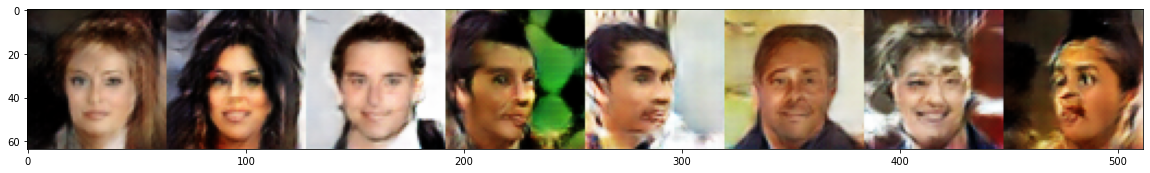

------------------------------
err_d 0.3759055733680725 2.730419874191284
[7/10 - 0/1271] Loss_D: 0.4455 Loss_G: 2.0707   D(G(z)): 0.7767 / 0.1474 / 0.1513
[7/10 - 127/1271] Loss_D: 1.2425 Loss_G: 5.6567   D(G(z)): 0.9535 / 0.6400 / 0.0059
[7/10 - 254/1271] Loss_D: 0.4202 Loss_G: 2.8047   D(G(z)): 0.8314 / 0.1791 / 0.0820
[7/10 - 381/1271] Loss_D: 0.7553 Loss_G: 1.5524   D(G(z)): 0.5492 / 0.0573 / 0.2616
[7/10 - 508/1271] Loss_D: 0.5107 Loss_G: 2.4153   D(G(z)): 0.7814 / 0.1936 / 0.1173
[7/10 - 635/1271] Loss_D: 0.4165 Loss_G: 2.5414   D(G(z)): 0.7804 / 0.1205 / 0.1051
[7/10 - 762/1271] Loss_D: 0.9372 Loss_G: 3.5303   D(G(z)): 0.9523 / 0.5124 / 0.0445
[7/10 - 889/1271] Loss_D: 0.5110 Loss_G: 1.7690   D(G(z)): 0.6846 / 0.0790 / 0.2139
[7/10 - 1016/1271] Loss_D: 0.5287 Loss_G: 1.8247   D(G(z)): 0.7180 / 0.1318 / 0.2077
[7/10 - 1143/1271] Loss_D: 0.5094 Loss_G: 4.2445   D(G(z)): 0.9045 / 0.3046 / 0.0202
[7/10 - 1270/1271] Loss_D: 0.6081 Loss_G: 3.3708   D(G(z)): 0.9200 / 0.3625 / 0.0481


<Figure size 432x288 with 0 Axes>

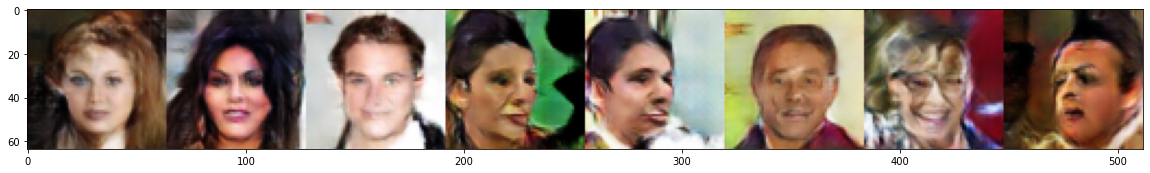

------------------------------
err_d 0.6081128716468811 3.370814085006714
[8/10 - 0/1271] Loss_D: 0.3792 Loss_G: 3.1210   D(G(z)): 0.8033 / 0.1185 / 0.0636
[8/10 - 127/1271] Loss_D: 0.6315 Loss_G: 2.1610   D(G(z)): 0.7008 / 0.1963 / 0.1520
[8/10 - 254/1271] Loss_D: 0.5418 Loss_G: 1.5523   D(G(z)): 0.6983 / 0.1116 / 0.2628
[8/10 - 381/1271] Loss_D: 0.3753 Loss_G: 3.0470   D(G(z)): 0.8639 / 0.1838 / 0.0652
[8/10 - 508/1271] Loss_D: 0.7687 Loss_G: 0.8829   D(G(z)): 0.5538 / 0.0811 / 0.4587
[8/10 - 635/1271] Loss_D: 0.5291 Loss_G: 3.8788   D(G(z)): 0.8922 / 0.3093 / 0.0270
[8/10 - 762/1271] Loss_D: 0.3485 Loss_G: 3.1565   D(G(z)): 0.8735 / 0.1699 / 0.0575
[8/10 - 889/1271] Loss_D: 0.3788 Loss_G: 2.7748   D(G(z)): 0.8914 / 0.2009 / 0.0818
[8/10 - 1016/1271] Loss_D: 1.0130 Loss_G: 1.1146   D(G(z)): 0.4479 / 0.0440 / 0.3981
[8/10 - 1143/1271] Loss_D: 0.5347 Loss_G: 4.0936   D(G(z)): 0.9095 / 0.3181 / 0.0252
[8/10 - 1270/1271] Loss_D: 0.3702 Loss_G: 2.9400   D(G(z)): 0.8957 / 0.2038 / 0.0715


<Figure size 432x288 with 0 Axes>

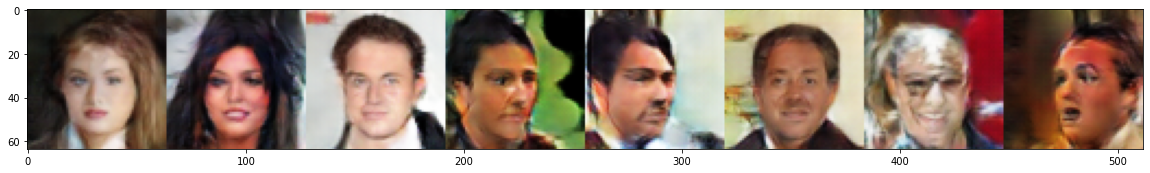

------------------------------
err_d 0.37018370628356934 2.9399800300598145
[9/10 - 0/1271] Loss_D: 0.3238 Loss_G: 3.6185   D(G(z)): 0.8971 / 0.1764 / 0.0355
[9/10 - 127/1271] Loss_D: 0.3425 Loss_G: 3.0177   D(G(z)): 0.9075 / 0.2021 / 0.0612
[9/10 - 254/1271] Loss_D: 0.4943 Loss_G: 2.4520   D(G(z)): 0.8210 / 0.2106 / 0.1159
[9/10 - 381/1271] Loss_D: 0.4188 Loss_G: 3.9908   D(G(z)): 0.9429 / 0.2759 / 0.0246
[9/10 - 508/1271] Loss_D: 0.3655 Loss_G: 2.5916   D(G(z)): 0.8245 / 0.1249 / 0.1082
[9/10 - 635/1271] Loss_D: 0.4708 Loss_G: 2.5787   D(G(z)): 0.7490 / 0.1280 / 0.1013
[9/10 - 762/1271] Loss_D: 0.3867 Loss_G: 2.7680   D(G(z)): 0.8057 / 0.1317 / 0.0824
[9/10 - 889/1271] Loss_D: 0.7046 Loss_G: 4.0004   D(G(z)): 0.9218 / 0.4085 / 0.0264
[9/10 - 1016/1271] Loss_D: 1.4019 Loss_G: 5.0631   D(G(z)): 0.9339 / 0.6395 / 0.0134
[9/10 - 1143/1271] Loss_D: 0.3565 Loss_G: 2.8987   D(G(z)): 0.8450 / 0.1524 / 0.0740
[9/10 - 1270/1271] Loss_D: 1.7553 Loss_G: 1.0534   D(G(z)): 0.2637 / 0.0440 / 0.4220

<Figure size 432x288 with 0 Axes>

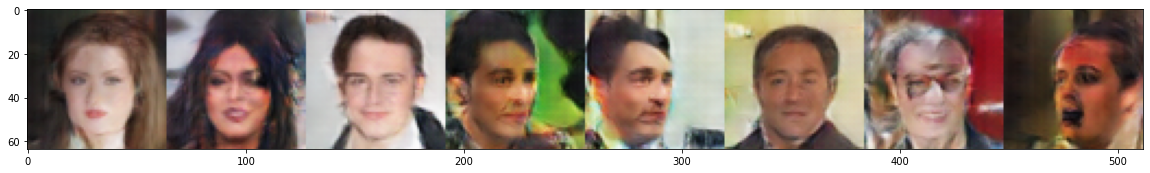

------------------------------
err_d 1.7552711963653564 1.0534065961837769
[10/10 - 0/1271] Loss_D: 1.2137 Loss_G: 2.6876   D(G(z)): 0.8558 / 0.5639 / 0.0989
[10/10 - 127/1271] Loss_D: 0.4037 Loss_G: 1.9751   D(G(z)): 0.8217 / 0.1525 / 0.1864
[10/10 - 254/1271] Loss_D: 0.4606 Loss_G: 3.2035   D(G(z)): 0.8415 / 0.2235 / 0.0580
[10/10 - 381/1271] Loss_D: 0.4596 Loss_G: 3.1704   D(G(z)): 0.8407 / 0.2162 / 0.0610
[10/10 - 508/1271] Loss_D: 0.5879 Loss_G: 1.0802   D(G(z)): 0.6218 / 0.0459 / 0.4121
[10/10 - 635/1271] Loss_D: 0.8181 Loss_G: 5.4993   D(G(z)): 0.9735 / 0.4888 / 0.0068
[10/10 - 762/1271] Loss_D: 0.8070 Loss_G: 2.6383   D(G(z)): 0.7541 / 0.3344 / 0.1082
[10/10 - 889/1271] Loss_D: 0.4693 Loss_G: 2.4369   D(G(z)): 0.7839 / 0.1633 / 0.1205
[10/10 - 1016/1271] Loss_D: 0.3450 Loss_G: 3.1183   D(G(z)): 0.8610 / 0.1556 / 0.0623
[10/10 - 1143/1271] Loss_D: 0.5523 Loss_G: 3.4917   D(G(z)): 0.9052 / 0.3293 / 0.0434
[10/10 - 1270/1271] Loss_D: 0.3823 Loss_G: 3.0119   D(G(z)): 0.8581 / 0.178

<Figure size 432x288 with 0 Axes>

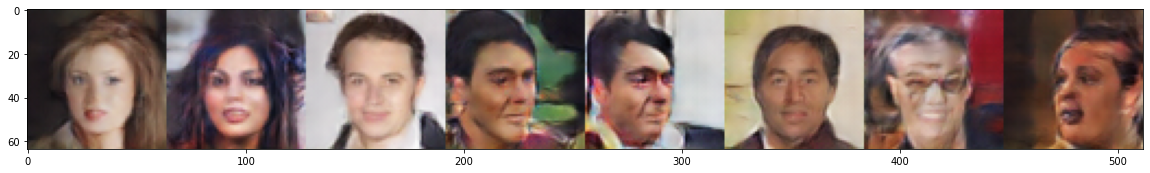

------------------------------
err_d 0.38225606083869934 3.011859893798828
avg loss 3.011859893798828


<Figure size 432x288 with 0 Axes>

In [13]:
from tqdm import tqdm

log_step = int(len(train_data) * 0.1)
for epoch in range(start_epoch, max_epoch + 1):
    loader = enumerate(train_data)
    # loader = tqdm(loader, total=len(train_data)) # if wanna use tqdm
    loss_list = []
    for i, (imgs, _) in loader:
        loss_temp = {
            'err_d': [],
            'err_g': []
        }
        # ========== Update Discriminator ==========
        net_d.zero_grad()
        
        # throw real image into discirminator
        real_imgs = imgs.to(device)
        
        output = net_d(real_imgs)
        err_d_real = criterion(output, real_label)
        d_x = output.mean().item()
        
        # throw fake image into discirminator
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=device)
        fake_imgs = net_g(noise)
        
        output = net_d(fake_imgs.detach())
        err_d_fake = criterion(output, fake_label)
        d_g_z1 = output.mean().item()
        
        # update
        err_d = err_d_real + err_d_fake
        loss_temp['err_d'].append(err_d.item())
        err_d.backward()
        optim_d.step()
        
        # ========== Update Generator ==========
        net_g.zero_grad()
        output = net_d(fake_imgs)
        err_g = criterion(output, real_label) # make generator make realer image
        loss_temp['err_g'].append(err_g.item())
        d_g_z2 = output.mean().item()
        err_g.backward()
        optim_g.step()
        
        if i % log_step == 0:
            print('[{}/{} - {}/{}] Loss_D: {:.4f} Loss_G: {:.4f}   D(G(z)): {:.4f} / {:.4f} / {:.4f}'.format(
                epoch, max_epoch, i, len(train_data),
                err_d.item(), err_g.item(), d_x, d_g_z1, d_g_z2
            ))

    torch.save({'net_d': net_d.state_dict(), 'net_g': net_g.state_dict(),
        'epoch': epoch, 'optim_d': optim_d.state_dict(), 'optim_g': optim_g.state_dict()
    }, 'ckpts/dcgan_epoch_{:02d}.pt'.format(epoch))

    fix_fake_imgs = net_g(fixed_noise).cpu().detach()
    plot_imgs(fix_fake_imgs[:8], True, file_name='out_imgs/e{:02}.png'.format(epoch))
    
    print('-' * 30)
    l_d = sum(loss_temp['err_d']) / len(loss_temp['err_d'])
    l_g = sum(loss_temp['err_g']) / len(loss_temp['err_g'])
    print('err_d', l_d, l_g)
    loss_list.append(l_g)
print('avg loss', sum(loss_list) / len(loss_list))

- Normal DCGAN
- ConvTranspose2d + ReLU, AdamW, Conv2d + LeakyReLU(0.2)
loss_g: 3.011859893798828, last:
- ConvTranspose2d + SELU, AdamW, Conv2d + SELU, weight not correctly init
loss_g: 4.460260391235352, last: 
- ConvTranspose2d + SELU, AdamW, Conv2d + SELU
loss_g: 4.460260391235352